In [2]:
# Load necessary libraries
if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}
BiocManager::install(c("minfi", "limma"))
install.packages("caret")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.0 (2023-04-21)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'minfi' 'limma'”
Installation paths not writeable, unable to update packages
  path: /u/local/apps/R/4.3.0/gcc10.2.0_intel2022.1.1/lib64/R/library
  packages:
    BiocGenerics, BiocParallel, Biostrings, bitops, boot, bslib, cachem, class,
    cli, cluster, codetools, colorspace, crayon, curl, data.table, deldir,
    digest, dqrng, evaluate, fansi, farver, fastmap, fitdistrplus, foreign, fs,
    future, future.apply, GenomeInfoDb, GenomeInfoDbData, GenomicRanges,
    ggplot2, globals, glue, gtable, highr, htmltools, httpuv, igraph, IRanges,
    jsonlite, KernSmooth, lattice, lifecycle, matrixStats, m

In [2]:
library(minfi)
library(limma)
library(caret) # For data splitting
library(survival)
library(dplyr)
library(data.table)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loa

In [3]:
transformed_methylation_data <- read.csv("/u/home/c/ctang04/Liver Project/data/transformed_log1k_methylation_data.csv", row.names = 1, check.names=FALSE)
# Load phenotype data
phenotype_matrix <- read.csv("/u/home/c/ctang04/Liver Project/data/patients.info.for.liver.study_with.seq.data_2024.07.21.csv", check.names = FALSE)

In [3]:
#saveRDS(transformed_methylation_data, file = "transformed_methyl_data_frame.RData")

In [4]:
dim(transformed_methylation_data)
dim(phenotype_matrix)

[1] 144965   5610

[1] 647  69

In [31]:
# Extract unique sample aliases from phenotype data
phenotype_sample_names <- phenotype_matrix$plasma_alias
split_pheno_names <- unlist(strsplit(as.character(phenotype_sample_names), "; "))
unique_sample_aliases <- unique(split_pheno_names)

# Match sample names between methylation and phenotype data
sample_names <- colnames(transformed_methylation_data)
matches <- sapply(sample_names, function(sample) any(grepl(sample, unique_sample_aliases)))
matched_sample_names <- sample_names[matches]

# Filter methylation data to include only matched samples
filtered_methyl_data <- transformed_methylation_data[, matched_sample_names, drop = FALSE]

# Split phenotype data to match the filtered methylation data
split_phenotype_data <- phenotype_matrix[rep(seq_len(nrow(phenotype_matrix)), sapply(phenotype_matrix$plasma_alias, function(x) length(strsplit(x, "; ")[[1]]))), ]
split_phenotype_data$plasma_alias <- unlist(strsplit(as.character(phenotype_matrix$plasma_alias), "; "))
split_phenotype_data <- split_phenotype_data[!is.na(split_phenotype_data$plasma_alias), ]

# Match common samples between methylation and phenotype data
common_samples <- intersect(colnames(filtered_methyl_data), split_phenotype_data$plasma_alias)
filtered_pheno_data <- split_phenotype_data[split_phenotype_data$plasma_alias %in% common_samples, ]
filtered_pheno_data <- filtered_pheno_data[match(colnames(filtered_methyl_data), filtered_pheno_data$plasma_alias), ]

# Combine methylation and phenotype data
transposed_methyl_data <- as.data.frame(t(filtered_methyl_data))
print(dim(transposed_methyl_data))
combined_data <- cbind(transposed_methyl_data, filtered_pheno_data)
print(dim(combined_data))

# Ensure no NA values in 'ast_U_L'
combined_data_clean <- combined_data[!is.na(combined_data$ast_U_L), ]
print(dim(combined_data_clean))

[1]    578 144965
[1]    578 145034
[1]    563 145034


In [32]:
combined_data_clean_aliases <- combined_data_clean[,"plasma_alias"]
#print(combined_data_clean_aliases)
rownames(combined_data_clean) <- combined_data_clean_aliases

In [7]:
write.csv(combined_data_clean, "/u/home/c/ctang04/Liver Project/data/alt_samples_withdup.csv")

In [33]:
# Remove duplicates in place by selecting the first sample for each donor
rownames_combined <- rownames(combined_data_clean)

combined_data_clean <- combined_data_clean %>%
  mutate(rowname = rownames_combined) %>%
  group_by(donor_id) %>%
  slice(1) %>%
  ungroup()

print(combined_data_clean$plasma_alias)

  [1] "plasma-2333-P9-LV"            "plasma-2300-P9-LV"           
  [3] "plasma-2270-P9-LV"            "plasma-1969-P9-LV"           
  [5] "plasma-1976-P9-N"             "plasma-2742-P9-N"            
  [7] "plasma-2800-P9-N"             "plasma-3931-P9-N"            
  [9] "plasma-2518-P9-N"             "plasma-2357-P9-N"            
 [11] "plasma-2873-P9-N"             "plasma-1959-P9-N"            
 [13] "plasma-3038-P9-LV"            "plasma-2091-P9-N"            
 [15] "plasma-3390-P9-LV"            "plasma-2741-P9-N"            
 [17] "plasma-2104-P9-N"             "plasma-2188-P9-BD"           
 [19] "plasma-3627-P9-LV"            "plasma-3134-P9-N"            
 [21] "plasma-2733-P9-N"             "plasma-2743-P9-N"            
 [23] "plasma-2778-P9-PR"            "plasma-2370-P9-N"            
 [25] "plasma-2248-P9-N"             "plasma-3427-P9-N"            
 [27] "plasma-2549-P9-N"             "plasma-2090-P9-N"            
 [29] "plasma-2441-P9-N"             "plasma-199

In [34]:
combined_data_clean_aliases_nodup <- combined_data_clean$plasma_alias
print(combined_data_clean_aliases_nodup)

  [1] "plasma-2333-P9-LV"            "plasma-2300-P9-LV"           
  [3] "plasma-2270-P9-LV"            "plasma-1969-P9-LV"           
  [5] "plasma-1976-P9-N"             "plasma-2742-P9-N"            
  [7] "plasma-2800-P9-N"             "plasma-3931-P9-N"            
  [9] "plasma-2518-P9-N"             "plasma-2357-P9-N"            
 [11] "plasma-2873-P9-N"             "plasma-1959-P9-N"            
 [13] "plasma-3038-P9-LV"            "plasma-2091-P9-N"            
 [15] "plasma-3390-P9-LV"            "plasma-2741-P9-N"            
 [17] "plasma-2104-P9-N"             "plasma-2188-P9-BD"           
 [19] "plasma-3627-P9-LV"            "plasma-3134-P9-N"            
 [21] "plasma-2733-P9-N"             "plasma-2743-P9-N"            
 [23] "plasma-2778-P9-PR"            "plasma-2370-P9-N"            
 [25] "plasma-2248-P9-N"             "plasma-3427-P9-N"            
 [27] "plasma-2549-P9-N"             "plasma-2090-P9-N"            
 [29] "plasma-2441-P9-N"             "plasma-199

In [10]:
write.csv(combined_data_clean, "/u/home/c/ctang04/Liver Project/data/alt_samples_nodup.csv")

In [35]:
as.data.frame(combined_data_clean)
rownames(combined_data_clean) <- combined_data_clean$plasma_alias

chr10_100027865_100027984,chr10_100028045_100028164,chr10_100028161_100028280,chr10_100028371_100028490,chr10_100069285_100069404,chr10_100108994_100109113,chr10_100174700_100174819,chr10_100174780_100174899,chr10_100206002_100206121,chr10_100206118_100206237,⋯,hbv_load_IU_L,hbv_antigen,hbv_hepatitis_delta_antibody,hbv_treatment,meld_score,meld_na_score,child_pugh_score,child_pugh_class,site_id_cc,rowname
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>
0.000000,0,0,0,1.379512,4.468386,2.764103,2.556595,0.000000,0.000000,⋯,NA,NA,NA,NA,11,NA,3,3,UCLA,plasma-2333-P9-LV
0.000000,0,0,0,1.613601,3.718647,2.201849,2.201849,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2300-P9-LV
1.515843,0,0,0,1.515843,4.497935,3.994503,3.495880,2.092668,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2270-P9-LV
0.000000,0,0,0,0.000000,4.102887,2.655036,2.390516,3.036790,0.000000,⋯,NA,NA,NA,NA,19,NA,6,A,UCLA,plasma-1969-P9-LV
0.000000,0,0,0,0.000000,3.661828,3.661828,3.484630,1.990893,1.990893,⋯,NA,NA,NA,NA,40,NA,3,3,UCLA,plasma-1976-P9-N
0.000000,0,0,0,1.253560,4.152138,4.565452,4.331834,2.141051,0.000000,⋯,NA,NA,NA,NA,NA,9,3,3,UCLA,plasma-2742-P9-N
0.000000,0,0,0,0.000000,4.431948,2.989978,3.163883,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2800-P9-N
0.000000,0,0,0,0.000000,4.532344,5.506428,5.373476,3.455014,3.065219,⋯,NA,NA,NA,NA,NA,NA,6,A,UCLA,plasma-3931-P9-N
0.000000,0,0,0,0.000000,3.025081,3.844242,3.975094,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2518-P9-N


Warning message:
“Setting row names on a tibble is deprecated.”


In [36]:
# Check if 'plasma_alias' is a column in the dataframe
"plasma_alias" %in% colnames(combined_data_clean)
"alt_U_L" %in% colnames(combined_data_clean)

[1] TRUE

[1] TRUE

In [37]:
# Find the largest value in the ast_U_L column
max_alt_U_L <- max(combined_data_clean$alt_U_L, na.rm = TRUE)

# Find the smallest value in the ast_U_L column
min_alt_U_L <- min(combined_data_clean$alt_U_L, na.rm = TRUE)

# Print the results
cat("The largest value in alt_U_L is:", max_alt_U_L, "\n")
cat("The smallest value in alt_U_L is:", min_alt_U_L, "\n")


The largest value in alt_U_L is: 1720 
The smallest value in alt_U_L is: 4 


# Log Transformation

In [38]:
# Ensure all values in ast_U_L are positive by adding a small constant (if necessary)
min_alt <- min(combined_data_clean$alt_U_L, na.rm = TRUE)
if (min_alt <= 0) {
  combined_data_clean$alt_U_L <- combined_data_clean$alt_U_L + (1 - min_alt)
}

# Apply log transformation to ast_U_L
combined_data_clean$log_alt_U_L <- log(combined_data_clean$alt_U_L)

# View the first few rows to verify the transformation
combined_data_clean <- as.data.frame(combined_data_clean)
rownames(combined_data_clean) <- combined_data_clean$plasma_alias
head(combined_data_clean)
# Convert to data.table and ensure all columns are numeric where appropriate
combined_data_clean_dt <- as.data.table(combined_data_clean)

,chr10_100027865_100027984,chr10_100028045_100028164,chr10_100028161_100028280,chr10_100028371_100028490,chr10_100069285_100069404,chr10_100108994_100109113,chr10_100174700_100174819,chr10_100174780_100174899,chr10_100206002_100206121,chr10_100206118_100206237,⋯,hbv_antigen,hbv_hepatitis_delta_antibody,hbv_treatment,meld_score,meld_na_score,child_pugh_score,child_pugh_class,site_id_cc,rowname,log_alt_U_L
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>
plasma-2333-P9-LV,0.000000,0,0,0,1.379512,4.468386,2.764103,2.556595,0.000000,0.000000,⋯,NA,NA,NA,11,NA,3,3,UCLA,plasma-2333-P9-LV,4.343805
plasma-2300-P9-LV,0.000000,0,0,0,1.613601,3.718647,2.201849,2.201849,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2300-P9-LV,2.708050
plasma-2270-P9-LV,1.515843,0,0,0,1.515843,4.497935,3.994503,3.495880,2.092668,0.000000,⋯,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2270-P9-LV,3.583519
plasma-1969-P9-LV,0.000000,0,0,0,0.000000,4.102887,2.655036,2.390516,3.036790,0.000000,⋯,NA,NA,NA,19,NA,6,A,UCLA,plasma-1969-P9-LV,3.218876
plasma-1976-P9-N,0.000000,0,0,0,0.000000,3.661828,3.661828,3.484630,1.990893,1.990893,⋯,NA,NA,NA,40,NA,3,3,UCLA,plasma-1976-P9-N,4.653960
plasma-2742-P9-N,0.000000,0,0,0,1.253560,4.152138,4.565452,4.331834,2.141051,0.000000,⋯,NA,NA,NA,NA,9,3,3,UCLA,plasma-2742-P9-N,4.382027


In [14]:
#print(rownames(combined_data_clean))
#print(rownames(combined_data_clean_dt))

# Removing Columns

In [39]:
columns_to_remove <- colnames(filtered_pheno_data)

# Remove columns in `combined_data_clean` that are present in `columns_to_remove`
combined_data_clean_filtered <- combined_data_clean[, !colnames(combined_data_clean) %in% columns_to_remove]

# Verify the dimensions of the cleaned dataset
print(dim(combined_data_clean_filtered))

[1]    465 144967


In [40]:
non_numeric_cols <- sapply(combined_data_clean, function(x) !is.numeric(x) && !is.integer(x))
print(names(combined_data_clean_dt)[non_numeric_cols])

 [1] "donor_id"                     "plasma_alias"                
 [3] "tumor_tissue_alias"           "normal_tissue_alias"         
 [5] "sample_source"                "info_source"                 
 [7] "phase_HBV"                    "gender"                      
 [9] "race"                         "hispanic"                    
[11] "specimen_collection_date"     "dx_cirrhosis"                
[13] "dx_hcc"                       "bclc_stage"                  
[15] "prime_etiology"               "non_prime_liver_disease_name"
[17] "prime_liver_disease_name"     "ascites"                     
[19] "ascietes_severity"            "encephalopathy"              
[21] "encephalopathy_severity"      "afp_ng_mL"                   
[23] "hbv_antigen"                  "hbv_hepatitis_delta_antibody"
[25] "hbv_treatment"                "child_pugh_class"            
[27] "site_id_cc"                   "rowname"                     


In [41]:
dim(combined_data)
dim(combined_data_clean)

[1]    578 145034

[1]    465 145036

# Split Training and Testing

In [42]:
library(caret)
library(limma)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$log_alt_U_L, k = k, list = TRUE, returnTrain = TRUE)

# Initialize lists to store results
all_predictions <- list()
all_performances <- vector()
all_top_markers <- list()

# Perform k-fold cross-validation manually
for (i in 1:k) {
  # Get the training and testing indices
  train_indices <- folds[[i]]
  test_indices <- setdiff(1:nrow(combined_data_clean), train_indices)
  
  # Subset the training and testing data
  training_set <- combined_data_clean[train_indices, ]
  testing_set <- combined_data_clean[test_indices, ]
  
  # Ensure the column names are correct for column removal
  columns_to_remove <- colnames(filtered_pheno_data)
  columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

  # Remove specified columns from the training data
  methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]
  
  # Create the design matrix
  design_train <- model.matrix(~ log_alt_U_L, data = training_set)
  
  # Remove 'log_alt_U_L' column from methylation data
  methylation_data_no_log_alt <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "log_alt_U_L"]

  # Check dimensions
  print(dim(design_train))  # Dimensions of design matrix
  print(dim(methylation_data_no_log_alt))  # Dimensions of filtered data

  # Fit the linear model
  fit <- lmFit(t(methylation_data_no_log_alt), design_train)
  fit <- eBayes(fit)
  
  # Get top 100 significant markers
  top_100_results <- topTable(fit, coef = 2, number = 100)
  top_100_markers <- rownames(top_100_results)
  
  # Store the top 100 markers for the current fold
  all_top_markers[[i]] <- top_100_markers
  # Export top 100 markers for the current fold to a CSV file
  write.csv(top_100_markers, file = paste0("ALT_Linear_top_100_markers_fold_", i, ".csv"), row.names = FALSE)
  
  # Filter training and testing data to include only the top 100 markers
  training_set_filtered <- training_set[, c("log_alt_U_L", top_100_markers)]
  testing_set_filtered <- testing_set[, c("log_alt_U_L", top_100_markers)]
  
  # Fit the linear model using the filtered training data
  model <- lm(log_alt_U_L ~ ., data = training_set_filtered)
  
  # Predict on the filtered testing set
  log_predictions <- predict(model, newdata = testing_set_filtered)
  predictions <- exp(log_predictions)
  
  # Store the predictions
  all_predictions[[i]] <- data.frame(
    PlasmaAlias = testing_set$plasma_alias,
    Actual = testing_set$alt_U_L,
    Predicted = predictions
  )
  
  # Calculate and store the performance metrics for the current fold
  performance <- postResample(predictions, testing_set$alt_U_L)
  all_performances <- rbind(all_performances, performance)
}



[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


In [44]:
# Calculate average performance across all folds
print(all_performances)
mean_performance <- colMeans(all_performances)
print(mean_performance)

# Print the top 100 markers for each fold
for (i in 1:k) {
  cat(paste("Top 100 markers for fold", i, ":\n"))
  print(all_top_markers[[i]])
}

# Find shared top markers across all folds after the loop
shared_markers <- Reduce(intersect, all_top_markers)

# Print the shared markers to a CSV file
write.csv(shared_markers, file = "ALT_shared_top_100_markers.csv", row.names = FALSE)

# Print the shared markers
cat("Shared markers across all folds:\n")
print(shared_markers)

                 RMSE     Rsquared      MAE
performance  33.94831 3.233720e-01 18.88661
performance  32.30642 4.929194e-02 20.76965
performance  22.85877 1.472760e-01 15.73412
performance 146.24573 1.068987e-05 35.88983
performance 172.73394 1.242897e-01 37.44825
      RMSE   Rsquared        MAE 
81.6186337  0.1288481 25.7456934 
Top 100 markers for fold 1 :
  [1] "chr19_50037666_50037785"   "chr6_134840719_134840838" 
  [3] "chr1_2232289_2232408"      "chr17_79258969_79259088"  
  [5] "chr7_154997274_154997393"  "chr3_126630259_126630378" 
  [7] "chr18_56555023_56555142"   "chr6_41528726_41528845"   
  [9] "chr15_100524231_100524350" "chr3_183273393_183273512" 
 [11] "chr10_79637818_79637937"   "chr4_2814004_2814123"     
 [13] "chr7_5735095_5735214"      "chr7_5735003_5735122"     
 [15] "chr1_36626683_36626802"    "chr11_75999259_75999378"  
 [17] "chr9_132906237_132906356"  "chr10_81163169_81163288"  
 [19] "chr19_17634190_17634309"   "chr19_13215478_13215597"  
 [21] "chr6_4167556

Shared markers across all folds:
 [1] "chr6_134840719_134840838"  "chr1_2232289_2232408"     
 [3] "chr17_79258969_79259088"   "chr7_154997274_154997393" 
 [5] "chr3_126630259_126630378"  "chr18_56555023_56555142"  
 [7] "chr6_41528726_41528845"    "chr15_100524231_100524350"
 [9] "chr3_183273393_183273512"  "chr10_79637818_79637937"  
[11] "chr7_5735095_5735214"      "chr1_36626683_36626802"   
[13] "chr11_75999259_75999378"   "chr10_81163169_81163288"  
[15] "chr6_41675560_41675679"    "chr19_2090100_2090219"    
[17] "chr10_81163296_81163415"   "chr16_89930592_89930711"  
[19] "chr3_52529393_52529512"    "chr22_37545852_37545971"  
[21] "chr15_75069586_75069705"   "chr10_106086020_106086139"
[23] "chr15_91373274_91373393"   "chr8_10574443_10574562"   
[25] "chr6_148688532_148688651" 


In [45]:
library(caret)
library(limma)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$log_alt_U_L, k = k, list = TRUE, returnTrain = TRUE)

# Initialize lists to store results
all_conf_matrices <- list()
all_top_markers <- list()
all_correlations <- numeric(k)

# Define classification thresholds
classify <- function(value) {
  if (value <= 33) {
    return(1)
  } else {
    return(2)
  }
}

# Perform k-fold cross-validation manually
for (i in 1:k) {
  # Get the training and testing indices
  train_indices <- folds[[i]]
  test_indices <- setdiff(1:nrow(combined_data_clean), train_indices)
  
  # Subset the training and testing data
  training_set <- combined_data_clean[train_indices, ]
  testing_set <- combined_data_clean[test_indices, ]
  
  # Ensure the column names are correct for column removal
  columns_to_remove <- colnames(filtered_pheno_data)
  columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

  # Remove specified columns from the training data
  methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]
  
  # Create the design matrix
  design_train <- model.matrix(~ log_alt_U_L, data = training_set)
  
  # Remove 'log_alt_U_L' column from methylation data
  methylation_data_no_log_alt <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "log_alt_U_L"]

  # Check dimensions
  print(dim(design_train))
  print(dim(methylation_data_no_log_alt))  

  # Fit the linear model
  fit <- lmFit(t(methylation_data_no_log_alt), design_train)
  fit <- eBayes(fit)
  
  # Get top 100 significant markers
  top_100_results <- topTable(fit, coef = 2, number = 100)
  top_100_markers <- rownames(top_100_results)
  
  # Store the top 100 markers for the current fold
  all_top_markers[[i]] <- top_100_markers
  # Export top 100 markers for the current fold to a CSV file
  #write.csv(top_100_markers, file = paste0("ALT_Linear_top_100_markers_fold_", i, ".csv"), row.names = FALSE)
  
  # Filter training and testing data to include only the top 100 markers
  training_set_filtered <- training_set[, c("log_alt_U_L", top_100_markers)]
  testing_set_filtered <- testing_set[, c(top_100_markers)]
  
  # Fit the linear model using the filtered training data
  model <- lm(log_alt_U_L ~ ., data = training_set_filtered)
  
  # Predict on the filtered testing set
  log_predictions <- predict(model, newdata = testing_set_filtered)
  predictions <- exp(log_predictions)  # Exponentiate the predictions
  
  # Exponentiate the actual values for comparison
  actual_values <- (testing_set$alt_U_L)
  
  # Print actual and predicted values before classification
  print(data.frame(
    PlasmaAlias = testing_set$plasma_alias,
    Actual = actual_values,
    Predicted = predictions
  ))
  
  # Classify predictions and actual values
  classified_predictions <- sapply(predictions, classify)
  classified_actuals <- sapply(actual_values, classify)
  
  # Convert predictions and actual values to factors
  classified_predictions <- factor(classified_predictions, levels = 1:2)
  classified_actuals <- factor(classified_actuals, levels = 1:2)
  
  # Create a confusion matrix
  conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
  all_conf_matrices[[i]] <- conf_matrix
  
  # Calculate Pearson's correlation coefficient
  correlation <- cor(actual_values, predictions)
  all_correlations[i] <- correlation
  
  # Print confusion matrix and Pearson's correlation for the current fold
  cat(paste("Fold", i, "Confusion Matrix:\n"))
  print(conf_matrix)
  cat(paste("Fold", i, "Pearson's Correlation Coefficient:", correlation, "\n"))
}

# Print confusion matrices for each fold
for (i in 1:k) {
  cat(paste("Confusion Matrix for fold", i, ":\n"))
  print(all_conf_matrices[[i]])
}


[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2333-P9-LV                       plasma-2333-P9-LV     77  32.23965
plasma-1969-P9-LV                       plasma-1969-P9-LV     25  29.11093
plasma-1976-P9-N                         plasma-1976-P9-N    105  27.71556
plasma-3931-P9-N                         plasma-3931-P9-N    187  96.15242
plasma-2357-P9-N                         plasma-2357-P9-N     41  32.76741
plasma-1959-P9-N                         plasma-1959-P9-N     78  14.00514
plasma-2104-P9-N                         plasma-2104-P9-N     24  15.05072
plasma-2296-P9-N                         plasma-2296-P9-N     19  23.33918
plasma-1970-P9-N                         plasma-1970-P9-N     75  61.78943
plasma-2072-P9-N                         plasma-2072-P9-N     29  32.06467
plasma-632-P9-CH                         plasma-632-P9-CH     37  45.53056
plasma-640-P9-CH                         plasma-640-P9-CH     17  28.65264
plasma-644-P9-CH         

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual  Predicted
plasma-3038-P9-LV                       plasma-3038-P9-LV     31  62.832126
plasma-2091-P9-N                         plasma-2091-P9-N      7  22.616979
plasma-2741-P9-N                         plasma-2741-P9-N    131  28.352079
plasma-3134-P9-N                         plasma-3134-P9-N      8   7.259886
plasma-2733-P9-N                         plasma-2733-P9-N     42  39.833527
plasma-2743-P9-N                         plasma-2743-P9-N     22  20.315710
plasma-2370-P9-N                         plasma-2370-P9-N     29  59.235277
plasma-3427-P9-N                         plasma-3427-P9-N    152  36.819245
plasma-2549-P9-N                         plasma-2549-P9-N     41  22.291244
plasma-2441-P9-N                         plasma-2441-P9-N    145  51.868757
plasma-2757-P9-N                         plasma-2757-P9-N     86  31.482221
plasma-4036-P9-N                         plasma-4036-P9-N     31  30.731640
plasma-3956-

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2300-P9-LV                       plasma-2300-P9-LV     15 24.964619
plasma-2518-P9-N                         plasma-2518-P9-N     38 26.218005
plasma-3390-P9-LV                       plasma-3390-P9-LV     52 23.874394
plasma-2248-P9-N                         plasma-2248-P9-N     10 25.470993
plasma-3620-P9-BD                       plasma-3620-P9-BD     95 44.890939
plasma-2770-P9-N                         plasma-2770-P9-N     27 30.793470
plasma-3462-P9-LV                       plasma-3462-P9-LV     72 30.500799
plasma-3377-P9-N                         plasma-3377-P9-N     47 47.472218
plasma-650-r1-t7-4day-P9-CH   plasma-650-r1-t7-4day-P9-CH     15 46.820269
plasma-654-P9-CH                         plasma-654-P9-CH     12 38.064736
plasma-3967-P9-CH                       plasma-3967-P9-CH    176 74.192467
plasma-1215-P9-CH                       plasma-1215-P9-CH     22 21.164137
plasma-746-P9-CH         

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2270-P9-LV                       plasma-2270-P9-LV     36 53.627152
plasma-2742-P9-N                         plasma-2742-P9-N     80 52.639293
plasma-2800-P9-N                         plasma-2800-P9-N     24 19.533576
plasma-2873-P9-N                         plasma-2873-P9-N     91 39.062369
plasma-2188-P9-BD                       plasma-2188-P9-BD     18 62.661293
plasma-3627-P9-LV                       plasma-3627-P9-LV     29 83.661138
plasma-2778-P9-PR                       plasma-2778-P9-PR    136  8.117013
plasma-2273-P9-N                         plasma-2273-P9-N     48 37.021926
plasma-3608-P9-LV                       plasma-3608-P9-LV     54 62.466119
plasma-2794-P9-N                         plasma-2794-P9-N     89 66.917582
plasma-636-r1-t7-4day-P9-CH   plasma-636-r1-t7-4day-P9-CH      9 48.430256
plasma-637-P9-CH                         plasma-637-P9-CH      7  6.322676
plasma-641-P9-CH         

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual  Predicted
plasma-2090-P9-N                         plasma-2090-P9-N     23  11.825937
plasma-1991-P9-N                         plasma-1991-P9-N     53  72.329546
plasma-2222-P9-N                         plasma-2222-P9-N     61  37.110261
plasma-3077-P9-N                         plasma-3077-P9-N      9  17.850217
plasma-4027-P9-N                         plasma-4027-P9-N    199  80.483799
plasma-3629-P9-LV                       plasma-3629-P9-LV    268  26.252897
plasma-3050-P9-N                         plasma-3050-P9-N     22  30.325558
plasma-3901-P9-N                         plasma-3901-P9-N     19  26.025099
plasma-3599-P9-LV                       plasma-3599-P9-LV     29  25.652456
plasma-3835-P9-N                         plasma-3835-P9-N     71  35.640386
plasma-3637-P9-LV                       plasma-3637-P9-LV     39  21.839742
plasma-3450-P9-BC                       plasma-3450-P9-BC     30  28.165601
plasma-646-P

Confusion Matrix for fold 1 :
Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 37 13
         2 17 26
                                          
               Accuracy : 0.6774          
                 95% CI : (0.5725, 0.7707)
    No Information Rate : 0.5806          
    P-Value [Acc > NIR] : 0.03571         
                                          
                  Kappa : 0.3469          
                                          
 Mcnemar's Test P-Value : 0.58388         
                                          
            Sensitivity : 0.6852          
            Specificity : 0.6667          
         Pos Pred Value : 0.7400          
         Neg Pred Value : 0.6047          
             Prevalence : 0.5806          
         Detection Rate : 0.3978          
   Detection Prevalence : 0.5376          
      Balanced Accuracy : 0.6759          
                                          
       'Positive' Class : 1               
      

# Random Forest

In [46]:
library(caret)
library(limma)
library(randomForest)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$log_alt_U_L, k = k, list = TRUE, returnTrain = TRUE)

# Initialize lists to store results
all_conf_matrices <- list()
all_top_markers <- list()

# Define classification thresholds
classify <- function(value) {
  if (value <= 33) {
    return(1)
  } else {
    return(2)
  }
}

# Perform k-fold cross-validation manually
for (i in 1:k) {
  # Get the training and testing indices
  train_indices <- folds[[i]]
  test_indices <- setdiff(1:nrow(combined_data_clean), train_indices)
  
  # Subset the training and testing data
  training_set <- combined_data_clean[train_indices, ]
  testing_set <- combined_data_clean[test_indices, ]
  
  # Ensure the column names are correct for column removal
  columns_to_remove <- colnames(filtered_pheno_data)
  columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

  # Remove specified columns from the training data
  methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]
  
  # Create the design matrix
  design_train <- model.matrix(~ log_alt_U_L, data = training_set)
  
  # Remove 'log_alt_U_L' column from methylation data
  methylation_data_no_log_alt <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "log_alt_U_L"]

  # Check dimensions
  print(dim(design_train))
  print(dim(methylation_data_no_log_alt))  

  # Fit the linear model
  fit <- lmFit(t(methylation_data_no_log_alt), design_train)
  fit <- eBayes(fit)
  
  # Get top 100 significant markers
  top_100_results <- topTable(fit, coef = 2, number = 100)
  top_100_markers <- rownames(top_100_results)
  
  # Store the top 100 markers for the current fold
  all_top_markers[[i]] <- top_100_markers
  # Export top 100 markers for the current fold to a CSV file
  #write.csv(top_100_markers, file = paste0("ALT_Linear_top_100_markers_fold_", i, ".csv"), row.names = FALSE)

  # Filter training and testing data to include only the top 100 markers
  training_set_filtered <- training_set[, c("log_alt_U_L", top_100_markers)]
  testing_set_filtered <- testing_set[, c(top_100_markers)]
  
  # Fit the Random Forest model using the filtered training data
  rf_model <- randomForest(log_alt_U_L ~ ., data = training_set_filtered, importance = TRUE)
  
  # Predict on the filtered testing set
  log_predictions <- predict(rf_model, newdata = testing_set_filtered)
  predictions <- exp(log_predictions)  # Exponentiate the predictions
  
  # Exponentiate the actual values for comparison
  actual_values <- testing_set$alt_U_L
  
  # Print actual and predicted values before classification
  print(data.frame(
    PlasmaAlias = testing_set$plasma_alias,
    Actual = actual_values,
    Predicted = predictions
  ))
  
  # Classify predictions and actual values
  classified_predictions <- sapply(predictions, classify)
  classified_actuals <- sapply(actual_values, classify)
  
  # Convert predictions and actual values to factors
  classified_predictions <- factor(classified_predictions, levels = 1:2)
  classified_actuals <- factor(classified_actuals, levels = 1:2)
  
  # Create a confusion matrix
  conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
  all_conf_matrices[[i]] <- conf_matrix
  
  # Print confusion matrix for the current fold
  cat(paste("Fold", i, "Confusion Matrix:\n"))
  print(conf_matrix)
}

# Print confusion matrices for each fold
for (i in 1:k) {
  cat(paste("Confusion Matrix for fold", i, ":\n"))
  print(all_conf_matrices[[i]])
}


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:minfi’:

    combine


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine




[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2333-P9-LV                       plasma-2333-P9-LV     77  33.37685
plasma-1969-P9-LV                       plasma-1969-P9-LV     25  26.90932
plasma-1976-P9-N                         plasma-1976-P9-N    105  47.89899
plasma-3931-P9-N                         plasma-3931-P9-N    187  50.53292
plasma-2357-P9-N                         plasma-2357-P9-N     41  48.86388
plasma-1959-P9-N                         plasma-1959-P9-N     78  40.56077
plasma-2104-P9-N                         plasma-2104-P9-N     24  21.29513
plasma-2296-P9-N                         plasma-2296-P9-N     19  26.60516
plasma-1970-P9-N                         plasma-1970-P9-N     75  42.48013
plasma-2072-P9-N                         plasma-2072-P9-N     29  25.52507
plasma-632-P9-CH                         plasma-632-P9-CH     37  44.32897
plasma-640-P9-CH                         plasma-640-P9-CH     17  20.44235
plasma-644-P9-CH         

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-3038-P9-LV                       plasma-3038-P9-LV     31  36.39867
plasma-2091-P9-N                         plasma-2091-P9-N      7  15.47106
plasma-2741-P9-N                         plasma-2741-P9-N    131  36.43560
plasma-3134-P9-N                         plasma-3134-P9-N      8  16.91239
plasma-2733-P9-N                         plasma-2733-P9-N     42  30.51033
plasma-2743-P9-N                         plasma-2743-P9-N     22  21.03330
plasma-2370-P9-N                         plasma-2370-P9-N     29  46.45792
plasma-3427-P9-N                         plasma-3427-P9-N    152  46.83963
plasma-2549-P9-N                         plasma-2549-P9-N     41  22.45515
plasma-2441-P9-N                         plasma-2441-P9-N    145  38.80542
plasma-2757-P9-N                         plasma-2757-P9-N     86  29.06930
plasma-4036-P9-N                         plasma-4036-P9-N     31  28.80929
plasma-3956-P9-N         

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2300-P9-LV                       plasma-2300-P9-LV     15  21.64594
plasma-2518-P9-N                         plasma-2518-P9-N     38  43.15683
plasma-3390-P9-LV                       plasma-3390-P9-LV     52  25.16216
plasma-2248-P9-N                         plasma-2248-P9-N     10  20.47968
plasma-3620-P9-BD                       plasma-3620-P9-BD     95  58.51455
plasma-2770-P9-N                         plasma-2770-P9-N     27  34.07881
plasma-3462-P9-LV                       plasma-3462-P9-LV     72  30.41276
plasma-3377-P9-N                         plasma-3377-P9-N     47  38.48093
plasma-650-r1-t7-4day-P9-CH   plasma-650-r1-t7-4day-P9-CH     15  33.00849
plasma-654-P9-CH                         plasma-654-P9-CH     12  24.35024
plasma-3967-P9-CH                       plasma-3967-P9-CH    176  66.21268
plasma-1215-P9-CH                       plasma-1215-P9-CH     22  21.59381
plasma-746-P9-CH         

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2270-P9-LV                       plasma-2270-P9-LV     36  60.00752
plasma-2742-P9-N                         plasma-2742-P9-N     80  51.61356
plasma-2800-P9-N                         plasma-2800-P9-N     24  20.15685
plasma-2873-P9-N                         plasma-2873-P9-N     91  46.66658
plasma-2188-P9-BD                       plasma-2188-P9-BD     18  54.15602
plasma-3627-P9-LV                       plasma-3627-P9-LV     29  56.67095
plasma-2778-P9-PR                       plasma-2778-P9-PR    136  22.50733
plasma-2273-P9-N                         plasma-2273-P9-N     48  45.02536
plasma-3608-P9-LV                       plasma-3608-P9-LV     54  58.41064
plasma-2794-P9-N                         plasma-2794-P9-N     89  55.71686
plasma-636-r1-t7-4day-P9-CH   plasma-636-r1-t7-4day-P9-CH      9  22.22528
plasma-637-P9-CH                         plasma-637-P9-CH      7  17.51195
plasma-641-P9-CH         

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2090-P9-N                         plasma-2090-P9-N     23  17.11810
plasma-1991-P9-N                         plasma-1991-P9-N     53  49.22258
plasma-2222-P9-N                         plasma-2222-P9-N     61  45.81827
plasma-3077-P9-N                         plasma-3077-P9-N      9  21.44814
plasma-4027-P9-N                         plasma-4027-P9-N    199  85.29707
plasma-3629-P9-LV                       plasma-3629-P9-LV    268  27.74782
plasma-3050-P9-N                         plasma-3050-P9-N     22  24.54422
plasma-3901-P9-N                         plasma-3901-P9-N     19  33.92481
plasma-3599-P9-LV                       plasma-3599-P9-LV     29  24.74869
plasma-3835-P9-N                         plasma-3835-P9-N     71  47.22957
plasma-3637-P9-LV                       plasma-3637-P9-LV     39  30.33900
plasma-3450-P9-BC                       plasma-3450-P9-BC     30  24.82221
plasma-646-P9-CH         

# TESTING AND TRAINING THE LINEAR MODEL

In [143]:
# Load necessary libraries
library(caret)
library(pROC)

# Define classification thresholds
classify <- function(value) {
  if (value <= 33) {
    return(1)
  } else {
    return(2)
  }
}

# Apply the classification to predictions and actual values
classified_predictions <- sapply(predictions, classify)
classified_actuals <- sapply(actual_values, classify)

# Ensure they are factors with levels 1, 2
classified_predictions <- factor(classified_predictions, levels = 1:2)
classified_actuals <- factor(classified_actuals, levels = 1:2)

# Check for NA values in classified predictions and actual values
print(sum(is.na(classified_predictions)))
print(sum(is.na(classified_actuals)))

# Check lengths
print(length(classified_predictions))
print(length(classified_actuals))

# Remove rows with NA values
valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
classified_predictions <- classified_predictions[valid_indices]
classified_actuals <- classified_actuals[valid_indices]

# Create a confusion matrix
conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)

# Print confusion matrix and metrics
print(conf_matrix)

# Calculate Accuracy
accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
cat("Accuracy:", accuracy, "\n")



# Calculate AUC for each class
roc_obj <- roc(classified_actuals, predictions)
auc_value <- auc(roc_obj)
cat("Model AUC:", auc_value, "\n")


[1] 0
[1] 0
[1] 91
[1] 91
Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 18 12
         2 25 36
                                          
               Accuracy : 0.5934          
                 95% CI : (0.4853, 0.6952)
    No Information Rate : 0.5275          
    P-Value [Acc > NIR] : 0.12387         
                                          
                  Kappa : 0.1713          
                                          
 Mcnemar's Test P-Value : 0.04852         
                                          
            Sensitivity : 0.4186          
            Specificity : 0.7500          
         Pos Pred Value : 0.6000          
         Neg Pred Value : 0.5902          
             Prevalence : 0.4725          
         Detection Rate : 0.1978          
   Detection Prevalence : 0.3297          
      Balanced Accuracy : 0.5843          
                                          
       'Positive' Class : 1               
          

Setting levels: control = 1, case = 2

Setting direction: controls < cases



Model AUC: 0.6749031 


`geom_smooth()` using formula = 'y ~ x'


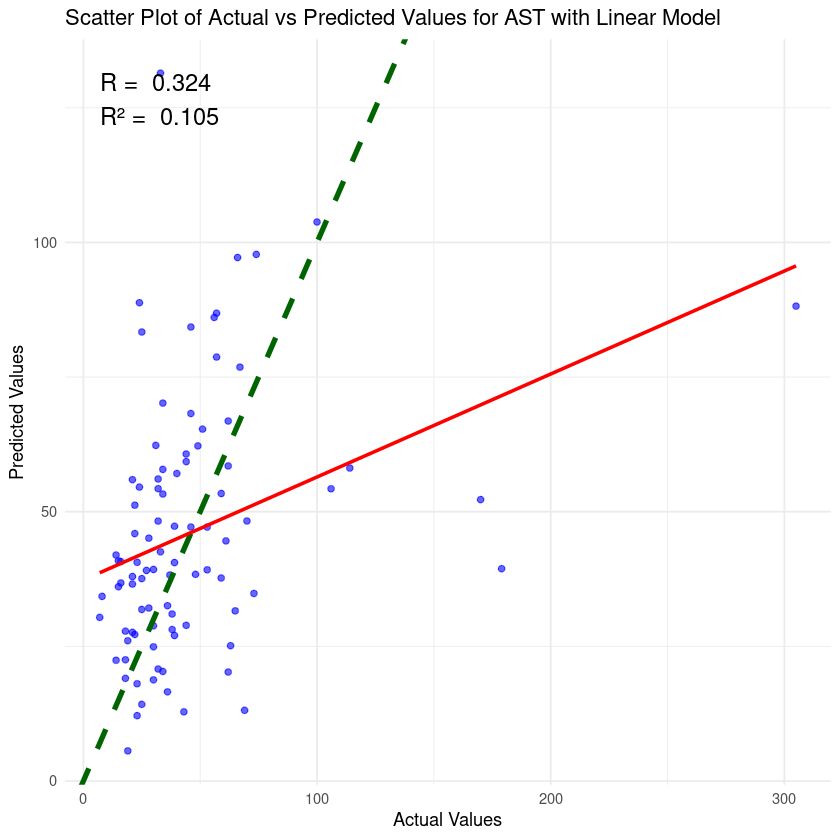

In [144]:
# Load necessary library
library(ggplot2)

# Ensure predictions and actual_values are numeric
predictions <- as.numeric(predictions)
actual_values <- as.numeric(actual_values)

# Create a data frame with actual and predicted values
df <- data.frame(
  Actual = actual_values,
  Predicted = predictions
)

# Calculate the Pearson correlation coefficient (R) and R²
r_value <- cor(df$Actual, df$Predicted)
r_squared <- r_value^2

# Plot the actual vs predicted values as a scatter plot
plot <- ggplot(df, aes(x = Actual, y = Predicted)) +
  geom_point(color = "blue", alpha = 0.6) + # scatter plot points in blue
  geom_abline(intercept = 0, slope = 1, color = "darkgreen", linetype = "dashed", size = 1.5) + # ideal line (y = x) in green dashed line
  geom_smooth(method = "lm", color = "red", se = FALSE) + # best fit line in red
  labs(title = "Scatter Plot of Actual vs Predicted Values for AST with Linear Model",
       x = "Actual Values",
       y = "Predicted Values") +
  annotate("text", x = min(df$Actual), y = max(df$Predicted), 
           label = paste("R = ", round(r_value, 3), "\nR² = ", round(r_squared, 3)),
           hjust = 0, vjust = 1, color = "black", size = 5) +
  theme_minimal()

# Display the plot
print(plot)


`geom_smooth()` using formula = 'y ~ x'


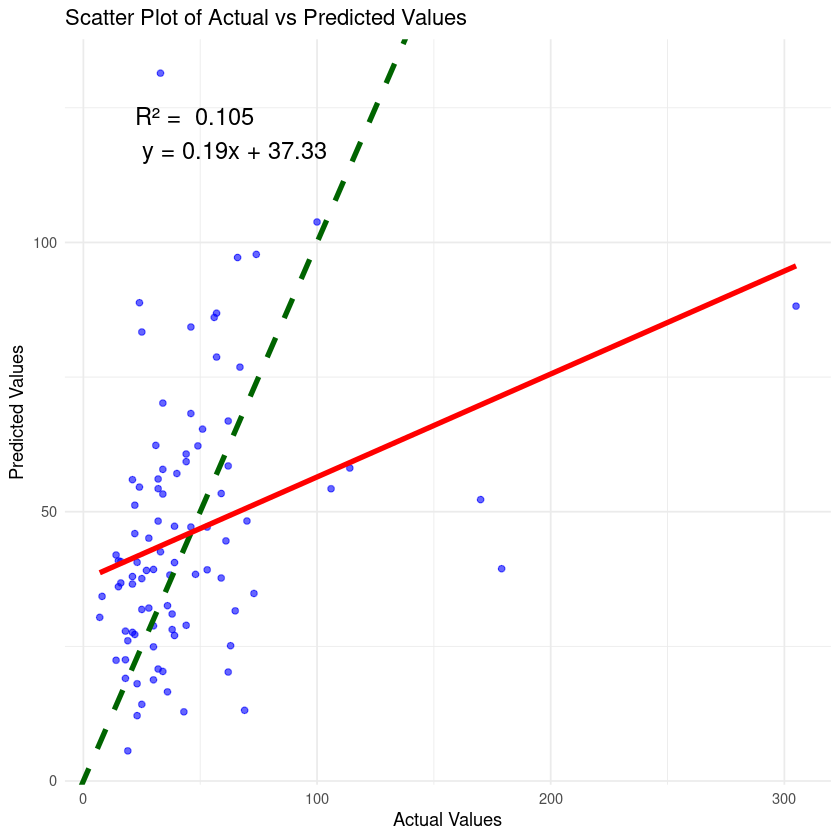

In [145]:
# Load necessary library
library(ggplot2)

# Ensure predictions and actual_values are numeric
predictions <- as.numeric(predictions)
actual_values <- as.numeric(actual_values)

# Create a data frame with actual and predicted values
df <- data.frame(
  Actual = actual_values,
  Predicted = predictions
)

# Calculate the Pearson correlation coefficient (R) and R²
r_value <- cor(df$Actual, df$Predicted)
r_squared <- r_value^2

# Fit a linear model
lm_fit <- lm(Predicted ~ Actual, data = df)
lm_eqn <- paste("y = ", round(coef(lm_fit)[2], 2), "x + ", round(coef(lm_fit)[1], 2), sep = "")

# Plot the actual vs predicted values as a scatter plot
plot <- ggplot(df, aes(x = Actual, y = Predicted)) +
  geom_point(color = "blue", alpha = 0.6) + # scatter plot points in blue
  geom_abline(intercept = 0, slope = 1, color = "darkgreen", linetype = "dashed", size = 1.5) + # ideal line (y = x) in green dashed line
  geom_smooth(method = "lm", color = "red", se = FALSE, size = 1.5) + # best fit line in red
  labs(title = "Scatter Plot of Actual vs Predicted Values",
       x = "Actual Values",
       y = "Predicted Values") +
  annotate("text", x = min(df$Actual) + (max(df$Actual) - min(df$Actual)) * 0.05, 
           y = max(df$Predicted) - (max(df$Predicted) - min(df$Predicted)) * 0.05, 
           label = paste("R² = ", round(r_squared, 3), "\n", lm_eqn),
           hjust = 0, vjust = 1, color = "black", size = 5) +
  theme_minimal()

# Display the plot
print(plot)


In [146]:
# Load necessary libraries
library(caret)
library(pROC)

# Define classification thresholds
classify <- function(value) {
  if (value <= 33) {
    return(1)
  } else {
    return(2)
  }
}

# Apply the classification to predictions and actual values
classified_predictions <- sapply(predictions, classify)
classified_actuals <- sapply(actual_values, classify)

# Ensure they are factors with levels 1, 2
classified_predictions <- factor(classified_predictions, levels = 1:2)
classified_actuals <- factor(classified_actuals, levels = 1:2)

# Check for NA values in classified predictions and actual values
print(sum(is.na(classified_predictions)))
print(sum(is.na(classified_actuals)))

# Check lengths
print(length(classified_predictions))
print(length(classified_actuals))

# Remove rows with NA values
valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
classified_predictions <- classified_predictions[valid_indices]
classified_actuals <- classified_actuals[valid_indices]

# Convert classified data back to numeric for Pearson correlation
# Convert factor levels to numeric (1 and 2)
numeric_predictions <- as.numeric(as.character(classified_predictions))
numeric_actuals <- as.numeric(as.character(classified_actuals))

# Create a confusion matrix
conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)

# Print confusion matrix and metrics
print(conf_matrix)

# Calculate Accuracy
accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
cat("Accuracy:", accuracy, "\n")

# Calculate Sensitivity and Specificity for each class
sensitivity <- conf_matrix$byClass[,"Sensitivity"]
specificity <- conf_matrix$byClass[,"Specificity"]
cat("Sensitivity:", sensitivity, "\n")
cat("Specificity:", specificity, "\n")

# Calculate AUC for each class
roc_obj <- roc(classified_actuals, predictions)
auc_value <- auc(roc_obj)
cat("Model AUC:", auc_value, "\n")


# Calculate Pearson's correlation coefficient
pearson_corr <- cor(numeric_actuals, numeric_predictions)
cat("Pearson's correlation coefficient:", pearson_corr, "\n")


[1] 0
[1] 0
[1] 91
[1] 91
Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 18 12
         2 25 36
                                          
               Accuracy : 0.5934          
                 95% CI : (0.4853, 0.6952)
    No Information Rate : 0.5275          
    P-Value [Acc > NIR] : 0.12387         
                                          
                  Kappa : 0.1713          
                                          
 Mcnemar's Test P-Value : 0.04852         
                                          
            Sensitivity : 0.4186          
            Specificity : 0.7500          
         Pos Pred Value : 0.6000          
         Neg Pred Value : 0.5902          
             Prevalence : 0.4725          
         Detection Rate : 0.1978          
   Detection Prevalence : 0.3297          
      Balanced Accuracy : 0.5843          
                                          
       'Positive' Class : 1               
          

ERROR: Error in conf_matrix$byClass[, "Sensitivity"]: incorrect number of dimensions


# Random Forest

In [ ]:
install.packages("randomForest")

In [147]:
library(randomForest)
library(caret)  # For confusionMatrix

# Convert continuous 'ast_U_L' into categorical classes
training_data$ast_U_L <- exp(training_data$log_ast_U_L)
training_data$ast_U_L_class <- cut(training_data$ast_U_L,
                                          breaks = c(-Inf, 33, Inf),
                                          labels = c("Class 1", "Class 2"))

# Train the Random Forest model
rf_model <- randomForest(ast_U_L_class ~ ., data = training_data, importance = TRUE)

# Predict on the training data
predictions <- predict(rf_model, newdata = training_data)

# Create confusion matrix
confusion_matrix <- confusionMatrix(predictions, training_data$ast_U_L_class)
print(confusion_matrix)

# Print feature importance
#print(importance(rf_model))


Confusion Matrix and Statistics

          Reference
Prediction Class 1 Class 2
   Class 1     188       0
   Class 2       0     186
                                     
               Accuracy : 1          
                 95% CI : (0.9902, 1)
    No Information Rate : 0.5027     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5027     
         Detection Rate : 0.5027     
   Detection Prevalence : 0.5027     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : Class 1    
                                     


In [160]:
# Convert continuous 'ast_U_L' into categorical classes in testing data
testing_data <- as.data.frame(testing_data)
"log_ast_U_L" %in% testing_data
"ast_U_L" %in% testing_data
combined_testing_data <- testing_data
combined_testing_data <- cbind(testing_data, ast_U_L = testing_pheno, log_ast_U_L = testing_pheno_log)
"log_ast_U_L" %in% colnames(combined_testing_data)
"ast_U_L" %in% colnames(combined_testing_data)
str(combined_testing_data$log_ast_U_L)
class(combined_testing_data$log_ast_U_L)

[1] FALSE

[1] FALSE

[1] TRUE

[1] TRUE

 num [1:91] 3.04 2.89 3.47 3.22 4.23 ...


[1] "numeric"

In [161]:
combined_testing_data$ast_U_L <- exp(combined_testing_data$log_ast_U_L)
combined_testing_data$ast_U_L_class <- cut(combined_testing_data$ast_U_L,
                                  breaks = c(-Inf, 33, Inf),
                                  labels = c("Class 1", "Class 2"))

# Predict on the testing data
predictions_test <- predict(rf_model, newdata = combined_testing_data)

# Create confusion matrix for testing data
confusion_matrix_test <- confusionMatrix(predictions_test, combined_testing_data$ast_U_L_class)
print(confusion_matrix_test)

# Extract confusion matrix values
conf_matrix <- confusion_matrix_test$table

# Predict probabilities on the testing data
predictions_prob <- predict(rf_model, newdata = combined_testing_data, type = "prob")

# Extract probabilities for "Class 2" (or the positive class)
prob_positive_class <- predictions_prob[, "Class 2"]

# Calculate ROC curve and AUC
roc_obj <- roc(combined_testing_data$ast_U_L_class, prob_positive_class, levels = rev(levels(combined_testing_data$ast_U_L_class)))
auc_value <- auc(roc_obj)

# Print the AUC
cat("Model AUC:", auc_value, "\n")

Confusion Matrix and Statistics

          Reference
Prediction Class 1 Class 2
   Class 1      43       0
   Class 2       0      48
                                     
               Accuracy : 1          
                 95% CI : (0.9603, 1)
    No Information Rate : 0.5275     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.4725     
         Detection Rate : 0.4725     
   Detection Prevalence : 0.4725     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : Class 1    
                                     


Setting direction: controls > cases



Model AUC: 1 


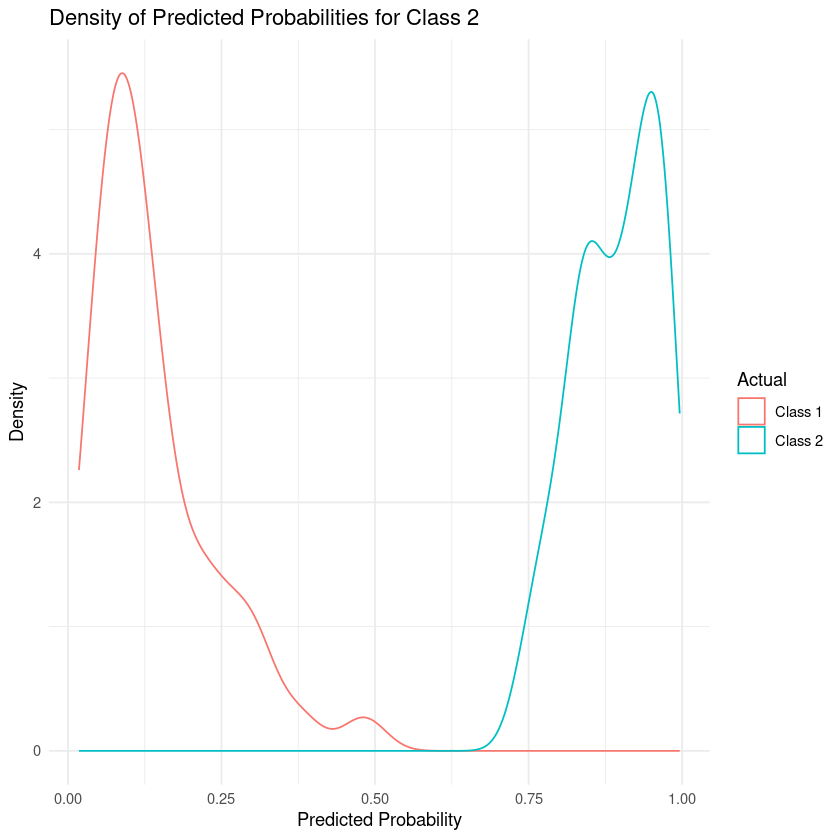

In [169]:
library(ggplot2)
library(dplyr)

# Convert actual and predicted values into a dataframe
results_df <- data.frame(
  Actual = combined_testing_data$ast_U_L_class,
  Predicted = predictions_test,
  Probability_Class2 = prob_positive_class
)

# Plot predicted probabilities for Class 2
ggplot(results_df, aes(x = Probability_Class2, color = Actual)) +
  geom_density() +
  labs(title = "Density of Predicted Probabilities for Class 2", x = "Predicted Probability", y = "Density") +
  theme_minimal()


In [164]:
# Combine actual and predicted scores into a data frame
results <- data.frame(
  Actual = combined_testing_data$ast_U_L_class,
  Predicted = predictions_test
)
library(pROC)

# Assume rf_model is your random forest model
# Assume combined_testing_data has the true class labels and pred_prob has the predicted probabilities

# Calculate ROC curves and AUCs for each class
roc_curves <- lapply(levels(combined_testing_data$ast_U_L_class), function(class) {
  if (class %in% colnames(pred_prob)) {
    roc(combined_testing_data$ast_U_L_class == class, pred_prob[, class])
  } else {
    warning(paste("Column for class", class, "is missing in pred_prob."))
    NULL
  }
})

# Compute AUC for each class
auc_values <- sapply(roc_curves, auc)

# Compute overall AUC (macro-average)
overall_auc <- mean(auc_values, na.rm = TRUE)

# Print overall AUC
cat("Overall AUC:", overall_auc, "\n")

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



Overall AUC: 1 


In [171]:
# Create confusion matrix for testing data
confusion_matrix_test <- confusionMatrix(predictions_test, combined_testing_data$ast_U_L_class)
print(confusion_matrix_test)

# Extract confusion matrix values
conf_matrix <- confusion_matrix_test$table
print(conf_matrix)

# Extract probabilities for "Class 2" (or the positive class)
prob_positive_class <- predictions_prob[, "Class 2"]

# Calculate ROC curve and AUC
roc_obj <- roc(combined_testing_data$ast_U_L_class, prob_positive_class, levels = rev(levels(combined_testing_data$ast_U_L_class)))
auc_value <- auc(roc_obj)

# Print the AUC
cat("Model AUC:", auc_value, "\n")

# Combine actual and predicted values into a dataframe for printing
results_df <- data.frame(
  Actual = combined_testing_data$ast_U_L_class,
  Predicted = predictions_test,
  Probability_Class2 = prob_positive_class
)

# Print the actual and predicted values
print(results_df)

Confusion Matrix and Statistics

          Reference
Prediction Class 1 Class 2
   Class 1      43       0
   Class 2       0      48
                                     
               Accuracy : 1          
                 95% CI : (0.9603, 1)
    No Information Rate : 0.5275     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.4725     
         Detection Rate : 0.4725     
   Detection Prevalence : 0.4725     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : Class 1    
                                     
          Reference
Prediction Class 1 Class 2
   Class 1      43   

Setting direction: controls > cases



Model AUC: 1 
                             Actual Predicted Probability_Class2
plasma-2300-P9-LV           Class 1   Class 1              0.104
plasma-2800-P9-N            Class 1   Class 1              0.076
plasma-2104-P9-N            Class 1   Class 1              0.080
plasma-2188-P9-BD           Class 1   Class 1              0.312
plasma-2778-P9-PR           Class 2   Class 2              0.826
plasma-2090-P9-N            Class 2   Class 2              0.840
plasma-3462-P9-LV           Class 1   Class 1              0.042
plasma-3377-P9-N            Class 2   Class 2              0.756
plasma-636-r1-t7-4day-P9-CH Class 1   Class 1              0.142
plasma-637-P9-CH            Class 1   Class 1              0.050
plasma-658-P9-CH            Class 1   Class 1              0.068
plasma-2198-t7-5day-P9-CH   Class 1   Class 1              0.058
plasma-2026-P9-CH           Class 1   Class 1              0.078
plasma-1279-P9-LV           Class 2   Class 2              0.982
plasma-746-

   Actual Predicted value
1 Class.1   Class.1    43
2 Class.2   Class.1     0
3 Class.1   Class.2     0
4 Class.2   Class.2    48


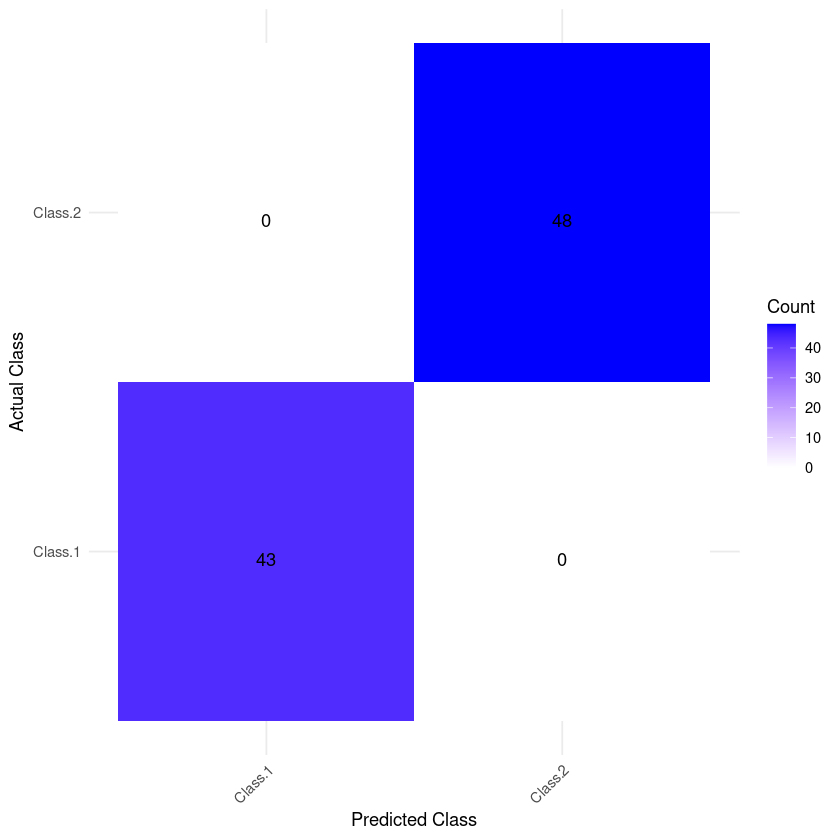

In [173]:
library(ggplot2)
library(reshape2)

# Extract confusion matrix from the confusionMatrix object
conf_matrix <- confusion_matrix_test$table

# Convert the confusion matrix to a matrix if it's not already
conf_matrix <- as.matrix(conf_matrix)

# Ensure column names and row names are set
rownames(conf_matrix) <- make.names(rownames(conf_matrix))
colnames(conf_matrix) <- make.names(colnames(conf_matrix))

# Melt the confusion matrix to long format for plotting
conf_matrix_melted <- melt(conf_matrix, varnames = c("Actual", "Predicted"))

# Print the melted dataframe to check its structure
print(conf_matrix_melted)

# Plot the confusion matrix
ggplot(conf_matrix_melted, aes(x = Predicted, y = Actual, fill = value)) +
  geom_tile() +
  geom_text(aes(label = value), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  labs(x = "Predicted Class", y = "Actual Class", fill = "Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Optional: Rotate x-axis labels for better readability
